In [1]:
import os
from symmer.symplectic.base import PauliwordOp
import json
import numpy as np
from ncon import ncon

ModuleNotFoundError: No module named 'symmer'

In [2]:
def expand_local_basis(H):
    i, _ = H.shape
    i = int(np.log2(i))
    
    H_ = H.reshape([2]*(i*2))
    return H_

In [3]:
from functools import reduce
from operator import iconcat

def group_opposite_legs(H_exp):
    l = len(H_exp.shape)
    offset = int(l / 2)
    tlist = [[i, i+offset] for i in range(offset)]
    tlist = reduce(iconcat, tlist, [])
    return H_exp.transpose(tlist)
    

In [4]:
def mpo_decomp_step(H_curr, Dmax=8):
    l = len(H_curr.shape)
    a, i, j = H_curr.shape[:3]
    
    M = H_curr.reshape(a*i*j, -1)
    
    U, S, V = truncated_SVD(M, Dmax=Dmax)
    
    D = len(S)

    A = U.reshape(a, i, j, D)
    M = np.diag(S) @ V

    M = M.reshape(D, *[2]*(l-4), 1)
    return A, M

In [5]:
def truncated_SVD(M, Dmax=None):
    U, S, V = np.linalg.svd(M, full_matrices=False)
    
    if Dmax is not None and len(S) > Dmax:
        S = S[:Dmax]
        U = U[:, :Dmax]
        V = V[:Dmax, :]
    
    return U, S, V

In [6]:
def construct_MPO(H_local, Dmax=8, debug=False):
    l = int(len(H_local.shape) / 2) - 1
    As = []
    M = H_local
    for i in range(l-1):
        A, M = mpo_decomp_step(M, Dmax)
        if debug:
            print(i)
            print('  A shape: {}'.format(A.shape))
            print('  M shape: {}'.format(M.shape))
        As.append(A)
    if debug:
        print(i+1)
        print('  A shape: {}'.format(M.shape))
    As.append(M)
    #As[-1] = ncon([As[-1], M], ((-1, -2, -3, 1), (1, -4)))
    return As

In [7]:
test_dir = os.path.join(os.path.dirname(os.getcwd()), 'tests')
ham_data_dir = os.path.join(test_dir, 'hamiltonian_data')

In [8]:
filename = 'H4_STO-3G_SINGLET_JW.json'

if filename not in os.listdir(ham_data_dir):
    raise ValueError('unknown file')
    
with open(os.path.join(ham_data_dir, filename), 'r') as infile:
    data_dict = json.load(infile)

### Test MPO Quimb with built in Ising Hamiltonian

In [9]:
from quimb.tensor.tensor_1d import MatrixProductOperator
from quimb.tensor.tensor_gen import MPO_ham_ising
from quimb.tensor.tensor_dmrg import DMRG2
from quimb.tensor.tensor_gen import SpinHam1D

In [10]:
def Ham_Ising(j=1.0, bx=0.0, S=1/2, cyclic=False):
    H = SpinHam1D(S=S, cyclic=cyclic)
    H += j, 'Z', 'Z'
    H -= bx, 'X'
    return H

In [11]:
mpo_ising = MPO_ham_ising(L = 4, bx=0.0)

In [12]:
print(mpo_ising)

MatrixProductOperator([
    Tensor(shape=(3, 2, 2), inds=('_20d2e3AAAAA', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(3, 3, 2, 2), inds=('_20d2e3AAAAA', '_20d2e3AAAAB', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(3, 3, 2, 2), inds=('_20d2e3AAAAB', '_20d2e3AAAAC', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(3, 2, 2), inds=('_20d2e3AAAAC', 'k3', 'b3'), tags=oset(['I3'])),
], L=4, max_bond=3)


In [13]:
dmrg = DMRG2(mpo_ising, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

In [14]:
dmrg.solve(tol=1e-6, verbosity=1)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|############################################| 3/3 [00:00<00:00, 132.57it/s]

Energy: -0.7500000000000003 ... not converged.
SWEEP-2, direction=R, max_bond=(2/20), cutoff:1e-10



100%|############################################| 3/3 [00:00<00:00, 422.87it/s]

Energy: -0.75 ... converged!


True

In [15]:
dmrg.state.show(max_width=80)

 1 1 1 
>─>─>─<
│ │ │ │


In [16]:
matrix_ising = Ham_Ising().build_sparse(4)
matrix_ising = matrix_ising.toarray()

In [17]:
matrix_exp = expand_local_basis(matrix_ising)
matrix_grouped = group_opposite_legs(matrix_exp)
matrix_grouped = np.expand_dims(matrix_grouped, axis=(0, -1))
As = construct_MPO(matrix_grouped, Dmax=16, debug=False)
As = [np.squeeze(A) for A in As]
my_MPO = MatrixProductOperator(As, 'ldur')

In [18]:
print(my_MPO)

MatrixProductOperator([
    Tensor(shape=(4, 2, 2), inds=('_20d2e3AAAAV', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(4, 16, 2, 2), inds=('_20d2e3AAAAV', '_20d2e3AAAAW', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(16, 4, 2, 2), inds=('_20d2e3AAAAW', '_20d2e3AAAAX', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(4, 2, 2), inds=('_20d2e3AAAAX', 'k3', 'b3'), tags=oset(['I3'])),
], L=4, max_bond=16)


In [19]:
mydmrg = DMRG2(my_MPO, bond_dims=10, cutoffs=1e-10)

In [20]:
mydmrg.solve(tol=1e-6, verbosity=1)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|############################################| 3/3 [00:00<00:00, 171.10it/s]

Energy: (-0.7499999999999998+1.2920900269473413e-17j) ... not converged.
SWEEP-2, direction=R, max_bond=(2/10), cutoff:1e-10



100%|############################################| 3/3 [00:00<00:00, 444.45it/s]

Energy: (-0.75+0j) ... converged!


True

### Constructing and MPO representation of H

In [21]:
H_op = PauliwordOp.from_dictionary(data_dict['hamiltonian'])

In [22]:
# list(data_dict['hamiltonian'].keys())

In [23]:
H_sparse = H_op.to_sparse_matrix

In [24]:
H = H_sparse.toarray()

In [25]:
H_exp = expand_local_basis(H)

In [26]:
H_grouped = group_opposite_legs(H_exp)

In [27]:
H_grouped.shape

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [28]:
H_grouped = np.expand_dims(H_grouped, axis=(0, -1))

In [29]:
H_grouped.shape

(1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)

In [30]:
As = construct_MPO(H_grouped, Dmax=32, debug=True)
As = [np.squeeze(A) for A in As]

0
  A shape: (1, 2, 2, 4)
  M shape: (4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)
1
  A shape: (4, 2, 2, 16)
  M shape: (16, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)
2
  A shape: (16, 2, 2, 32)
  M shape: (32, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)
3
  A shape: (32, 2, 2, 32)
  M shape: (32, 2, 2, 2, 2, 2, 2, 2, 2, 1)
4
  A shape: (32, 2, 2, 32)
  M shape: (32, 2, 2, 2, 2, 2, 2, 1)
5
  A shape: (32, 2, 2, 16)
  M shape: (16, 2, 2, 2, 2, 1)
6
  A shape: (16, 2, 2, 4)
  M shape: (4, 2, 2, 1)
7
  A shape: (4, 2, 2, 1)


### Groundstate Optimisation Using Quimb

In [31]:
from quimb.tensor.tensor_1d import MatrixProductOperator
from quimb.tensor.tensor_dmrg import DMRG2

In [32]:
def WordOpToMPO(wordop, max_bond_dim=16):
    H_sparse = H_op.to_sparse_matrix
    H = H_sparse.toarray()
    H_exp = expand_local_basis(H)
    H_grouped = group_opposite_legs(H_exp)
    H_grouped = np.expand_dims(H_grouped, axis=(0, -1))
    As = construct_MPO(H_grouped, Dmax=max_bond_dim, debug=False)
    As = [np.squeeze(A) for A in As]
    return MatrixProductOperator(As, 'ldur')

In [33]:
H_MPO = MatrixProductOperator(As, 'ldur')

In [34]:
print(H_MPO)

MatrixProductOperator([
    Tensor(shape=(4, 2, 2), inds=('_20d2e3AAAAn', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(4, 16, 2, 2), inds=('_20d2e3AAAAn', '_20d2e3AAAAo', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(16, 32, 2, 2), inds=('_20d2e3AAAAo', '_20d2e3AAAAp', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(32, 32, 2, 2), inds=('_20d2e3AAAAp', '_20d2e3AAAAq', 'k3', 'b3'), tags=oset(['I3'])),
    Tensor(shape=(32, 32, 2, 2), inds=('_20d2e3AAAAq', '_20d2e3AAAAr', 'k4', 'b4'), tags=oset(['I4'])),
    Tensor(shape=(32, 16, 2, 2), inds=('_20d2e3AAAAr', '_20d2e3AAAAs', 'k5', 'b5'), tags=oset(['I5'])),
    Tensor(shape=(16, 4, 2, 2), inds=('_20d2e3AAAAs', '_20d2e3AAAAt', 'k6', 'b6'), tags=oset(['I6'])),
    Tensor(shape=(4, 2, 2), inds=('_20d2e3AAAAt', 'k7', 'b7'), tags=oset(['I7'])),
], L=8, max_bond=32)


In [35]:
dmrg = DMRG2(H_MPO, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

In [36]:
dmrg.solve(verbosity=1, tol=1e-6)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|#############################################| 7/7 [00:00<00:00, 63.42it/s]

Energy: (-1.8742847352978442-5.551115123125783e-17j) ... not converged.
SWEEP-2, direction=R, max_bond=(10/20), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 194.32it/s]

Energy: (-1.874298515459389+1.1102230246251565e-16j) ... not converged.
SWEEP-3, direction=R, max_bond=(11/100), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 119.46it/s]

Energy: (-1.874299926360662+0j) ... not converged.
SWEEP-4, direction=R, max_bond=(11/100), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 141.52it/s]

Energy: (-1.8743003458526968+0j) ... converged!


True

In [37]:
energies = dmrg.energies

In [38]:
print(energies)

[(-1.8742847352978442-5.551115123125783e-17j), (-1.874298515459389+1.1102230246251565e-16j), (-1.874299926360662+0j), (-1.8743003458526968+0j)]


In [39]:
import matplotlib.pyplot as plt

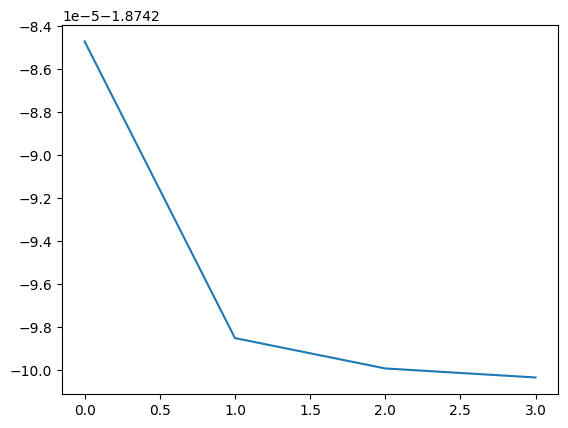

In [40]:
plt.plot(np.real(energies))

In [41]:
dmrg.state.show()

 2 4 8 10 8 4 2 
>─>─>─>──>─>─>─●
│ │ │ │  │ │ │ │


### Prepare exact ground state energy and state for example state

In [42]:
from symmer.utils import exact_gs_energy
from symmer.symplectic import QuantumState

In [43]:
meta = data_dict['data']

In [44]:
meta.keys()

dict_keys(['qubit_encoding', 'unit', 'geometry', 'basis', 'charge', 'spin', 'hf_array', 'n_particles', 'n_qubits', 'convergence_threshold', 'point_group', 'calculated_properties', 'auxiliary_operators'])

In [45]:
meta['calculated_properties']

{'HF': {'energy': -1.333349777097312, 'converged': True},
 'MP2': {'energy': -1.6161399127016058, 'converged': True},
 'CCSD': {'energy': -1.8261847366338488, 'converged': True},
 'FCI': {'energy': -1.86439214542294, 'converged': True}}

In [46]:
gs_energy, gs_vec = exact_gs_energy(H_sparse)

In [47]:
gs_energy

-1.8743019741837266

In [48]:
gs_state = QuantumState.from_array(gs_vec).cleanup(zero_threshold=1e-5)

In [49]:
gs_state

-0.084-0.274j |00011011> +
 0.084+0.274j |00100111> +
-0.021-0.067j |01011010> +
 0.103+0.335j |01100110> +
-0.082-0.268j |01101001> +
-0.082-0.268j |10010110> +
 0.103+0.335j |10011001> +
-0.021-0.067j |10100101> +
 0.135+0.439j |11011000> +
-0.135-0.439j |11100100>

In [50]:
gs_state.dagger * gs_state

(1.0000000000000013+0j)

### Compare DMRG state to exact ground state

In [51]:
dmrg_state = dmrg.state.to_dense()

In [52]:
dmrg_state = QuantumState.from_array(dmrg_state).cleanup(zero_threshold=1e-5)

In [53]:
dmrg_state.dagger * dmrg_state # Close to normalised

(0.999999998943531+0j)

Checking overlap with the exact gs and comparing the ground state energy. 

In [54]:
gs_overlap = np.linalg.norm(gs_state.dagger * dmrg_state)

print(f"DMRG state overlap with GS: {gs_overlap}")

DMRG state overlap with GS: 0.9998332710287409


In [55]:
gs_energy = -1*np.linalg.norm(gs_state.dagger * H_op * gs_state)
dmrg_energy = -1*np.linalg.norm(dmrg_state.dagger * H_op * dmrg_state)
hf_energy = meta['calculated_properties']['HF']['energy']

print(f"GS energy: {gs_energy} (no particle conservation)")
print(f"HF energy: {hf_energy}")
print(f"DMRG energy: {dmrg_energy}")

GS energy: -1.8743019741837204 (no particle conservation)
HF energy: -1.333349777097312
DMRG energy: -1.874300344442988


Note that the closeness to the exact GS energy can be tuned by the truncation of the MPO to represent the Hamiltonian. 

For example:

- Bond dim = 16 $\rightarrow$ GS overlap $\approx$ 0.2
- Bond dim = 32 $\rightarrow$ GS overlap $\approx$ 0.9998537440310613

### Partial Reconstruction of Operator

- We want to initially build and MPO to represent the HF terms of Pauli Word Op
- Once this is done we will sequentially add the off diagional terms starting with the terms of the largest magnitude. 

In [56]:
ham_dict = data_dict['hamiltonian']

In [57]:
sorted_dict = dict(sorted(ham_dict.items(), key=lambda x: np.linalg.norm(x[1]), reverse=True))

In [58]:
import re
def filter_dict(op_dict, regex="Z"):
    def has_match(test, reg):
        match = re.search(reg, test)
        if match is None:
            return False
        return True
    
    newDict = dict(filter(lambda x: has_match(x[0], regex), op_dict.items()))
    return newDict
        

In [59]:
new_dict = filter_dict(sorted_dict, "^[^XY]+$")

In [60]:
H_truncated_op = PauliwordOp.from_dictionary(new_dict)

In [61]:
H_truncated_op

-1.081+0.000j IIIIIIII +
 0.116+0.000j IIIIZZII +
 0.116+0.000j IIZZIIII +
 0.101+0.000j IIIZIIZI +
 0.101+0.000j IIZIIIIZ +
 0.099+0.000j IZIIZIII +
 0.099+0.000j ZIIIIZII +
 0.094+0.000j IIIIIIZZ +
 0.091+0.000j ZZIIIIII +
 0.077+0.000j IZIIIIZI +
 0.077+0.000j ZIIIIIIZ +
 0.071+0.000j IIIIIZZI +
 0.071+0.000j IIIIZIIZ +
 0.069+0.000j IZZIIIII +
 0.069+0.000j ZIIZIIII +
 0.065+0.000j IZIIIIII +
 0.065+0.000j ZIIIIIII +
 0.054+0.000j IZIIIIIZ +
 0.054+0.000j ZIIIIIZI +
 0.054+0.000j IIIZZIII +
 0.054+0.000j IIZIIZII +
 0.054+0.000j IIIZIZII +
 0.054+0.000j IIZIZIII +
 0.050+0.000j IZIZIIII +
 0.050+0.000j ZIZIIIII +
 0.050+0.000j IIIIIZIZ +
 0.050+0.000j IIIIZIZI +
 0.042+0.000j IZIIIZII +
 0.042+0.000j ZIIIZIII +
 0.042+0.000j IIIZIIIZ +
 0.042+0.000j IIZIIIZI +
 0.038+0.000j IIIIZIII +
 0.038+0.000j IIIIIZII +
 0.038+0.000j IIZIIIII +
 0.038+0.000j IIIZIIII +
 0.014+0.000j IIIIIIIZ +
 0.014+0.000j IIIIIIZI

In [62]:
MPO_trunc = WordOpToMPO(H_truncated_op)

In [63]:
dmrg = DMRG2(MPO_trunc, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

In [64]:
dmrg.solve(verbosity=1, tol=1e-6)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|#############################################| 7/7 [00:00<00:00, 96.63it/s]

Energy: (-1.9046517608857467+7.771756818902419e-07j) ... not converged.
SWEEP-2, direction=R, max_bond=(10/20), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 152.80it/s]

Energy: (-1.904653311945034+7.146443765178225e-07j) ... not converged.
SWEEP-3, direction=R, max_bond=(10/100), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 195.77it/s]

Energy: (-1.9046552725410468+8.246192592755493e-07j) ... not converged.
SWEEP-4, direction=R, max_bond=(9/100), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 282.43it/s]

Energy: (-1.904657620859284+9.156104068793261e-07j) ... not converged.
SWEEP-5, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 146.71it/s]

Energy: (-1.904660838770116+1.0530602546350945e-06j) ... not converged.
SWEEP-6, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 178.68it/s]

Energy: (-1.9046656941155615+1.2165350286742066e-06j) ... not converged.
SWEEP-7, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 306.56it/s]


Energy: (-1.9046736838999485+1.4825955353785225e-06j) ... not converged.
SWEEP-8, direction=R, max_bond=(9/200), cutoff:1e-10


100%|############################################| 7/7 [00:00<00:00, 163.23it/s]

Energy: (-1.904687996584115+1.8688115800231594e-06j) ... not converged.
SWEEP-9, direction=R, max_bond=(10/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 201.95it/s]

Energy: (-1.90471647835081+2.6091298825151044e-06j) ... not converged.
SWEEP-10, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 334.40it/s]

Energy: (-1.9047974911668306+4.538026354472535e-06j) ... not converged.


False

In [65]:
energies = dmrg.energies

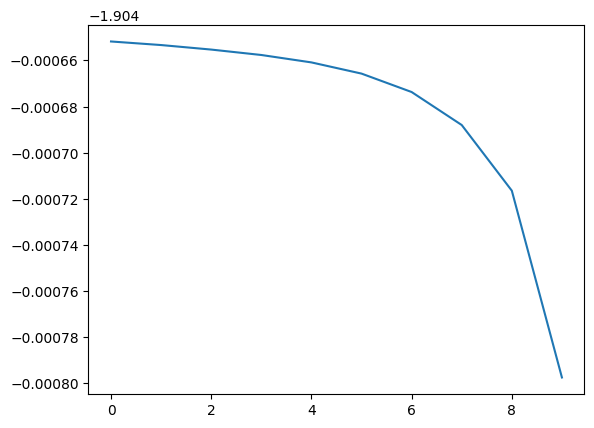

In [66]:
plt.plot(np.real(energies))

In [67]:
trunc_state = dmrg.state.to_dense()
trunc_mps = dmrg.state

In [68]:
trunc_state = QuantumState.from_array(trunc_state).cleanup(zero_threshold=1e-5)

In [69]:
trunc_state.dagger * trunc_state # Close to normalised

(0.9999999988394837+0j)

In [70]:
trunc_overlap = np.linalg.norm(gs_state.dagger * trunc_state)

print(f"Truncated state overlap with GS: {trunc_overlap}")

Truncated state overlap with GS: 0.07531738520015971


In [71]:
gs_energy = -1*np.linalg.norm(gs_state.dagger * H_op * gs_state)
trunc_energy = -1*np.linalg.norm(trunc_state.dagger * H_op * trunc_state)

print(f"GS energy: {gs_energy} (no particle conservation)")
print(f"Trunc energy: {trunc_energy}")

GS energy: -1.8743019741837204 (no particle conservation)
Trunc energy: -1.858447297106388


In [72]:
missing_dict = filter_dict(sorted_dict, "[XY]")
missing_word_op = PauliwordOp.from_dictionary(missing_dict)
print(missing_word_op)

-0.059+0.000j IIXXIIYY +
 0.059+0.000j IIXYIIYX +
 0.059+0.000j IIYXIIXY +
-0.059+0.000j IIYYIIXX +
-0.057+0.000j XXIIYYII +
 0.057+0.000j XYIIYXII +
 0.057+0.000j YXIIXYII +
-0.057+0.000j YYIIXXII +
 0.035+0.000j IXZZXYYI +
-0.035+0.000j IXZZYYXI +
-0.035+0.000j IYZZXXYI +
 0.035+0.000j IYZZYXXI +
-0.035+0.000j XZZZXXZX +
-0.035+0.000j XZZZXYZY +
-0.035+0.000j YZZZYXZX +
-0.035+0.000j YZZZYYZY +
-0.033+0.000j IXXYZZYI +
 0.033+0.000j IXYYZZXI +
 0.033+0.000j IYXXZZYI +
-0.033+0.000j IYYXZZXI +
 0.033+0.000j XZXXZZZX +
 0.033+0.000j XZXYZZZY +
 0.033+0.000j YZYXZZZX +
 0.033+0.000j YZYYZZZY +
 0.028+0.000j IXZZIZZX +
 0.028+0.000j IYZZIZZY +
 0.028+0.000j XZZZZIXI +
 0.028+0.000j YZZZZIYI +
-0.027+0.000j IXIZZZZX +
-0.027+0.000j IYIZZZZY +
-0.027+0.000j XZZIZZXI +
-0.027+0.000j YZZIZZYI +
-0.024+0.000j XXIIIIYY +
 0.024+0.000j XYIIIIYX +
 0.024+0.000j YXIIIIXY +
-0.024+0.000j YYIIIIXX +
-0.021+0.000j IIIIXXYY +
 0.021+0.000j IIIIXYYX +
 0.021+0.000j IIIIYXXY +
-0.021+0.000j IIIIYYXX +


In [73]:
MPO_missing = WordOpToMPO(missing_word_op, max_bond_dim=16)

In [74]:
MPO_recons = MPO_trunc + MPO_missing 

In [75]:
dmrg = DMRG2(MPO_recons, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10, p0=trunc_mps)

In [76]:
dmrg.solve(verbosity=1, tol=1e-6)

SWEEP-1, direction=R, max_bond=(9/10), cutoff:1e-10


100%|############################################| 7/7 [00:00<00:00, 141.62it/s]

Energy: (-3.814809751122256-1.6074253572639918e-07j) ... not converged.
SWEEP-2, direction=R, max_bond=(9/20), cutoff:1e-10



100%|#############################################| 7/7 [00:00<00:00, 65.80it/s]

Energy: (-3.8148100162231895+9.205467210726681e-08j) ... converged!


True

In [77]:
energies = dmrg.energies

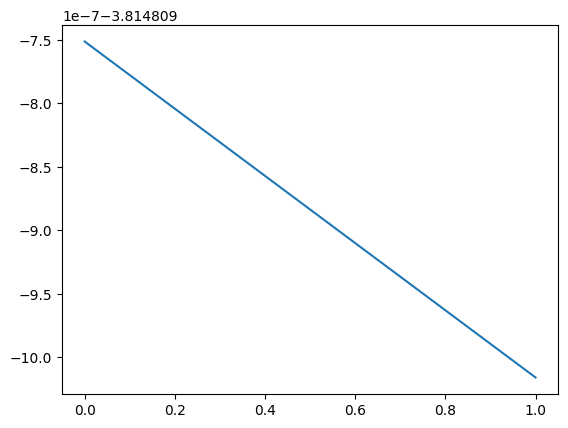

In [78]:
plt.plot(np.real(energies))

In [79]:
recons_state = dmrg.state.to_dense()

In [80]:
recons_state = QuantumState.from_array(recons_state).cleanup(zero_threshold=1e-5)

In [81]:
recons_overlap = np.linalg.norm(gs_state.dagger * recons_state)

print(f"Truncated state overlap with GS: {recons_overlap}")

Truncated state overlap with GS: 0.027561576284541586


In [82]:
gs_energy = -1*np.linalg.norm(gs_state.dagger * H_op * gs_state)
recons_energy = -1*np.linalg.norm(recons_state.dagger * H_op * recons_state)

print(f"GS energy: {gs_energy} (no particle conservation)")
print(f"Trunc energy: {recons_energy}")

GS energy: -1.8743019741837204 (no particle conservation)
Trunc energy: -1.8589081649298251


For some reason the reconstruction of the MPO by sequential adding terms does not seem to improve performance. At least in this case where we separate the terms containing only `Z` and `I` from the other terms and construct a state from them first. 

Not sure why this is. 